In [1]:
import pymongo
from pymongo import MongoClient
import csv
import os
from petl import fromcsv, look, cut, tocsv 
import numpy as np
from StringIO import StringIO
import sklearn
from sklearn import linear_model
import plotly 
import plotly.plotly as py
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from geopy.distance import vincenty
from scipy.stats import norm
from numpy import linspace
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from pylab import plot,show,hist,figure,title
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from scipy.stats import norm
import scipy.stats
from matplotlib.legend_handler import HandlerLine2D
import math
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
#importing the data scrapted from public database

def p2f(x):
    return float(x.strip('%'))/100

county2labor = pd.read_csv('CA_county_employment.csv').as_matrix()
for i in range(1,county2labor.shape[0]):
    county2labor[i,5] = p2f(county2labor[i,5])
county2LF=county2labor[:,[0,2,5]]
for i in range(1,county2LF.shape[0]):
    county2LF[i,1]=int(county2LF[i,1])
county2LF[0,2] ='unemploy_rate'

propTax = pd.read_csv('CA_propTax.csv').as_matrix()
propTax[22,7] = '0'
propTax[58,7] = '0'

for i in range(1,propTax.shape[0]):
    propTax[i,7] = p2f(propTax[i,7])
propTax[22,7] = np.median(propTax[:,7])
propTax[58,7] = np.median(propTax[:,7])

propTax[0,0]='County'
propTax = propTax[:,[0,7]]
propTax[0,1]='midTax'

zip2county = pd.read_csv('CA_zip2county.csv').as_matrix()
zip2county = zip2county[:,[0,2]]
zip2county[0,0]='zipcd'
zip2county[0,1]='County'

for i in range(1,zip2county.shape[0]):
    zip2county[i,0]=int(zip2county[i,0])

df1=pd.DataFrame(county2LF, columns=['County', 'Labor Force', 'unemploy_rate'])
df2=pd.DataFrame(propTax, columns=['County', 'midTax'])
df3=pd.DataFrame(zip2county, columns=['zipcd', 'County'])

df_merge=df1.merge(df2,on='County')
df_merge_merge=df3.merge(df_merge,on='County')
df_zip2countyInfo = df_merge_merge.ix[1:] # zipcd',County', 'Labor Force', 'unemploy_rate', 'midTax'


In [3]:
%matplotlib inline
#%qtconsole
data = pd.read_csv('soldPend_home_all.csv').as_matrix()

low_memory=False
mylist=[]
u, indices =np.unique(data[:,3], return_index=True)
data_uni = data[indices,:]
data=data_uni
                            

idx=[0,1,5,7,18]
data[:,idx]=data[:,idx]/1000 #convert price unit to $k
data[:,11]=2016-data[:,11] #convert year_built to age

idx_forFlip=np.where(data[:,16]==True)
data[:,16]=1
data[idx_forFlip,16]=2

idx_takedown=np.where(data[:,6]==True)
data[:,6]=1
data[idx_takedown,6]=2


#handeling the non-exist and nonsense zipcd
noZip = pd.isnull(data[:,2])
idx_noZip=np.where(noZip==True)
data = np.delete(data,idx_noZip,0)

for i in range(0,data.shape[0]):
    if (type(data[i,2]) is str):
        #print data[i,2]
        data[i,2] = int(data[i,2][:5])
        #print data[i,2]
idx_misZip=np.where(data[:,2]<90000)   
data = np.delete(data,idx_misZip,0)


idx_soldyearFilter=np.where(data[:,13]>10000)
data=np.delete(data,idx_soldyearFilter,0)
idx_lotFilter=np.where(data[:,12]>2*pow(10,11))
data=np.delete(data,idx_lotFilter,0)
idx_sqftFilter=np.where(data[:,17]>400000)
data=np.delete(data,idx_sqftFilter,0)
idx_misSqft=np.where(data[:,17]<20)
data=np.delete(data,idx_misSqft,0)
                 
idx_priceFilter=np.where(data[:,18]>200000)
data=np.delete(data,idx_priceFilter,0)

#handling the unreasonable year_built
idx_yearFilter=np.where(data[:,11]<0)
data[idx_yearFilter,11]=np.median(data[:,11])
idx_yearFilter=np.where(data[:,11]>500)
data[idx_yearFilter,11]=np.median(data[:,11])

data_forComp=data

col_null = pd.isnull(data[:,1])
idx_prepriceExist=np.where(col_null==True)
data=np.delete(data,idx_prepriceExist,0)



/Users/Cindy/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
#imputing #bed and #bath, drop other missing data
numBath_mis=np.where(data[:,4]>100) #remove an outlier in the numBath
data=np.delete(data,numBath_mis,0)

noBath = pd.isnull(data[:,4])
idx_noBath=np.where(noBath==True)
data[idx_noBath,4]=np.median(data[:,4])

idx_0Bath = np.where(data[:,4]==0)
data[idx_0Bath,4]=np.median(data[:,4])

noBed = pd.isnull(data[:,10])
idx_noBed=np.where(noBed==True)
data[idx_noBed,9]=np.median(data[:,10])

idx_0Bed = np.where(data[:,10]==0)
data[idx_0Bed,9]=np.median(data[:,10])

for i in range(0,19):
    col_null = pd.isnull((data[:,i]))
    idx=np.where(col_null==True)
    data=np.delete(data,idx,0)

In [5]:
# step1

df=pd.DataFrame(data, columns=['pre_sqft_price','pre_price','zipcd','propID','numBath','sqft_price','takedown',\
                               'cur_lis_price','lat','longt','numBed','year_built','lot_sqft','numDays','year',\
                               'month','forFlip','sqft','price'])

df_statbyZip = df['price'].astype(float).groupby(df['zipcd']).agg([np.median,np.mean,np.std,np.max,np.min,len])

data_statbyZip = df_statbyZip.as_matrix()
b=(np.unique(data[:,2])).reshape((df_statbyZip.shape[0],1))
data_statbyZip=np.append(data_statbyZip,b,1)

df_statbyZip=pd.DataFrame(data_statbyZip, columns=['median','mean','std','max','min','count','zipcd'])
df_additional = df_statbyZip.merge(df_zip2countyInfo,on='zipcd')
df_all=df.merge(df_additional,on='zipcd')

data_all=df_all.as_matrix()
data_all[:,[18,28]]=data_all[:,[28,18]]
data_all[:,[0,3]]=data_all[:,[3,0]]
data_all[:,[1,2]]=data_all[:,[2,1]]

#remove houses that has most likely mis input of sqft and which that has unreasonalbe price per sqft

var_noNeed=[3,5,7,20,21,22,23,25]
data_model=np.delete(data_all,var_noNeed,1)  #delete the variable that are not needed

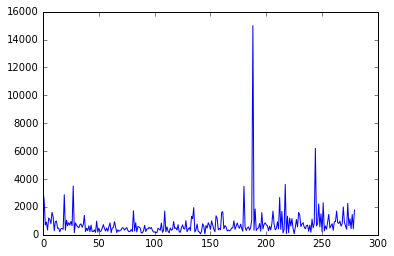

In [29]:
idx=range(0,280000,1000)
plt.plot(data_model[idx,20])

In [100]:
fields_data_all=['propID','zipcd','pre_price','pre_sqft_price','numBath','sqft_price','takedown','cur_lis_price',\
             'lat','longt','numBed','year_built','lot_sqft','numDays','year','month',\
             'forFlip','sqft','midTax','median','mean','std','max','min','len','County','Labor Force',\
        'unemploy_rate','price']
for index in np.arange(len(fields_data_all)):
    print str(index) + "," + fields_data_all[index]

0,pre_sqft_price
1,zipcd
2,propID
3,numBath
4,sqft_price
5,takedown
6,cur_lis_price
7,lat
8,longt
9,numBed
10,year_built
11,lot_sqft
12,numDays
13,year
14,month
15,forFlip
16,sqft
17,midTax
18,median
19,mean
20,std
21,max
22,min
23,len
24,County
25,Labor Force
26,unemploy_rate
27,price


In [620]:
fields_data_model=['propID','zipcd','pre_price','numBath','takedown',\
             'lat','longt','numBed','year_built','lot_sqft','numDays','year','month',\
             'forFlip','sqft','midTax','median','len','Labor Force','unemploy_rate','price']
for index in np.arange(len(fields_data_model)):
    print str(index) + "," + fields_data_model[index]

0,propID
1,numBath
2,takedown
3,cur_lis_price
4,lat
5,longt
6,numBed
7,year_built
8,lot_sqft
9,numDays
10,year
11,month
12,forFlip
13,sqft
14,midTax
15,median
16,mean
17,max
18,min
19,len
20,Labor Force
21,unemploy_rate
22,price


In [6]:
def pctErr_cal(testID):

    # generate train and test set
    #print ('The house interested is: ') + str(data_model[testID,0])
    #print ('It was sold ') + str(data_model[testID,10]) + ' days ago at $' + str(data_model[testID,20]) +'k'

    Y_test=data_model[testID,20] -data_model[testID,2]   # for sold price-list price
    Y_train = np.delete(data_model[:,20]-data_model[:,2], testID, 0)# for sold price, 20; for list price, 2
    loc_train = np.delete(data_model[:,:20], testID, 0)
    loc_test = data_model[testID,:20]

    dist_miles=[]
    for i in range(0,loc_train.shape[0]):
        dist_miles.append(vincenty(loc_test[5:7], loc_train[i,5:7]).miles)

    dist=np.asarray(dist_miles)
    dist_sorted = np.sort(dist)

    top = 5000
    dist_selected = dist_sorted[0:top]

    loc_match_id=[np.where(dist == dist_selected[x])[0] for x in range(0,top)]
    loc_match_id = np.concatenate(loc_match_id).ravel()
    loc_match_id = np.unique(loc_match_id)

    feature1=loc_train[loc_match_id,2:]
    dist_feature = dist[loc_match_id]
    Y_train = Y_train[loc_match_id]
     
    feature=np.vstack((feature1.T, dist_feature.T))
    feature=feature.T    
    
    idx_priceFilter = np.where(Y_train[:]>3*loc_test[2])
    idx_priceFilter = np.asarray(idx_priceFilter)
    feature=np.delete(feature,idx_priceFilter,0)
    Y_train=np.delete(Y_train,idx_priceFilter,0)

    idx_sqftFilter = np.where(feature[:,12]>3*loc_test[14])
    idx_sqftFilter = np.asarray(idx_sqftFilter)
    feature=np.delete(feature,idx_sqftFilter,0)
    Y_train=np.delete(Y_train,idx_sqftFilter,0)

    idx_lotsqftFilter = np.where(feature[:,7]>3*loc_test[9])
    idx_lotsqftFilter = np.asarray(idx_lotsqftFilter)
    feature=np.delete(feature,idx_lotsqftFilter,0)
    Y_train=np.delete(Y_train,idx_lotsqftFilter,0)

    idx_numDaysFilter = np.where(feature[:,8] < loc_test[10])
    idx_numDaysFilter = np.asarray(idx_numDaysFilter)
    feature=np.delete(feature,idx_numDaysFilter,0)
    Y_train=np.delete(Y_train,idx_numDaysFilter,0)     

    feature_test =np.append(loc_test[2:], 0)

    if feature.shape[0]==0:
        feature = feature_test.reshape((1,feature_test.shape[0]))
        Y_train = np.asarray([1])    
    feature2 = np.vstack(feature[:, 1:]).astype(np.float) #to not using list price as one of the feature
    feature_test2 = np.vstack(feature_test[1:]).astype(np.float) #to not using list price as one of the feature
    
    #feature2 = np.vstack(feature[:,:]).astype(np.float) #to use list price as one of the feature
    #feature_test2 = np.vstack(feature_test).astype(np.float) #to use list price as one of the feature
    
    scaler = preprocessing.StandardScaler().fit(feature2)
    X_scaled = scaler.transform(feature2)  
    X_scaled_normed = preprocessing.normalize(X_scaled, norm='l2')

    X_test_scaled = scaler.transform(feature_test2.reshape(1, -1))  
    X_test_scaled_normed= preprocessing.normalize(X_test_scaled.reshape(1, -1) , norm='l2')
    X_test_scaled_normed = X_test_scaled_normed[:,:]

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(1,interaction_only=True)
    X_train = poly.fit_transform(X_scaled_normed)  
    X_test = poly.fit_transform(X_test_scaled_normed.reshape(1, -1) )  

    for i in range(1,X_train.shape[1]):
        col_null = pd.isnull((X_train[:,i]))
        idx=np.where(col_null==True)
        X_train=np.delete(X_train,idx,0)
        Y_train=np.delete(Y_train,idx,0)
        col_null2 = pd.isnull((Y_train[:]))
        idx2=np.where(col_null2==True)
        X_train=np.delete(X_train,idx2,0)
        Y_train=np.delete(Y_train,idx2,0)

    #print ('the training set size is: [') + str(X_train.shape[0]) +',' + str(X_train.shape[1]) +']'
    rf=RandomForestRegressor()
    #RR=linear_model.Ridge(alpha =1) 
    #svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    clf= rf
    clf.fit(X_train,Y_train)
    diff_est=clf.predict(X_test)
    return (diff_est, Y_test)

diff_est = []
diff_true=[]
num_test=0
group=0
for i in range(0,280000,1000):
    diff, Ytrue = pctErr_cal(i)
    diff_est.append(diff)
    diff_true.append(Ytrue)
    num_test=num_test+1
    if num_test == 20:
        scipy.io.savemat('diff'+str(group)+'_top5000.mat', {'diff_est':diff_est,'diff_true':diff_true})
        group=group+1
        num_test=num_test-20